# COTTON DISEASE PREDICTION USING TRANSFER LEARNING RESNET152V2 

# Enabling and testing the GPU 

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# TensorFlow speedup on GPU relative to CPU

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print(
      '\n\nThis error most likely means that this notebook is not '
      'configured to use a GPU.  Change this in Notebook Settings via the '
      'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
  raise SystemError('GPU device not found')

def cpu():
  with tf.device('/cpu:0'):
    random_image_cpu = tf.random.normal((100, 100, 100, 3))
    net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
    return tf.math.reduce_sum(net_cpu)

def gpu():
  with tf.device('/device:GPU:0'):
    random_image_gpu = tf.random.normal((100, 100, 100, 3))
    net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
    return tf.math.reduce_sum(net_gpu)
  
# We run each op once to warm up; see: https://stackoverflow.com/a/45067900
cpu()
gpu()

# Run the op several times.
print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
      '(batch x height x width x channel). Sum of ten runs.')
print('CPU (s):')
cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
print(cpu_time)
print('GPU (s):')
gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
print(gpu_time)
print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))

Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images (batch x height x width x channel). Sum of ten runs.
CPU (s):
3.1846009000000066
GPU (s):
0.1059240310000007
GPU speedup over CPU: 30x


In [ ]:
import tensorflow
tensorflow.__version__

'2.3.1'

In [ ]:
# Importing the libraries
from tensorflow.keras.layers import Input, Lambda, Dense, Flatten  # Input,Lambda,Dense,Flatten
from tensorflow.keras.models import Model 
from tensorflow.keras.applications.resnet50 import ResNet50 # The Transfer Learning technique used is ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img # ImageDataGenerator is mainly for data augmentation(rotating,flipping the images etc)
from tensorflow.keras.models import Sequential
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# Linking the drive account
 
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Resizing the images
IMAGE_SIZE = [224, 224]

train_path = 'C:\Home\Courses\Machine Learning\Projects\Cotton_Disease_Prediction\Datasets\train'
valid_path = 'C:\Home\Courses\Machine Learning\Projects\Cotton_Disease_Prediction\Datasets\test'

In [ ]:
# Importing the Resnet152V2 library and adding the preprocessing layer to the front of Resnet
# Here we will be using imagenet weights
import tensorflow
resnet152V2 = tensorflow.keras.applications.ResNet152V2(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)
# This is having an RGB image so we have to use 3 channels,if its black and white then only 1. Here we are using the pretrained weights.include_top = False so here we have to ignore the top layer.
# We even have to remove the output layer(in Resnet there are 1000 categories but for our problem there are only 4 categories so we remove the output layer and add our own output layer with 4 categories)

234553344/234545216 [==============================] - 79s 0us/step


In [ ]:
# We dont need to train existing weights(as we are already using the pre trained weights)
for layer in resnet152V2.layers:
    layer.trainable = False

In [ ]:
# Useful for getting number of output classes
folders = glob('/content/drive/My Drive/COTTON_DISEASE/train/*')

In [ ]:
# Our layers - we can add more 
x = Flatten()(resnet152V2.output) # Flattening it(based on our categories)

In [ ]:
len(folders)

4

In [ ]:
prediction = Dense(len(folders), activation='softmax')(x)

In [ ]:
# Creating a model object
model = Model(inputs = resnet152V2.input, outputs = prediction)

In [ ]:
# Summary of the model, This Resnet has 50 layers and the no of outputs are 4
model.summary()


Model: "functional_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 114, 114, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [ ]:
# Cost and optimization methods to use
model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)


In [ ]:
# Use the Image Data Generator to import the images from the dataset, Data Augmentation for the training dataset
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

In [ ]:
# Target size should be same as the initialized one(here 224,224)
training_set = train_datagen.flow_from_directory('/content/drive/My Drive/COTTON_DISEASE/train/',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'categorical')

Found 1951 images belonging to 4 classes.


In [ ]:
test_set = test_datagen.flow_from_directory('/content/drive/My Drive/COTTON_DISEASE/test/',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'categorical')

Found 18 images belonging to 4 classes.


In [ ]:
# Fitting the model
r = model.fit(
  training_set,
  validation_data=test_set,
  epochs=20, 
  steps_per_epoch=len(training_set),
  validation_steps=len(test_set)
)
# Batch size is 32 and 61 is the number of batches(32 X 61 = 1952 images)

Epoch 1/20
61/61 [==============================] - 52s 856ms/step - loss: 1.3436 - accuracy: 0.8093 - val_loss: 1.2632 - val_accuracy: 0.8333
Epoch 2/20
61/61 [==============================] - 38s 629ms/step - loss: 0.5169 - accuracy: 0.9226 - val_loss: 0.0043 - val_accuracy: 1.0000
Epoch 3/20
61/61 [==============================] - 39s 636ms/step - loss: 0.3220 - accuracy: 0.9462 - val_loss: 0.5524 - val_accuracy: 0.9444
Epoch 4/20
61/61 [==============================] - 39s 633ms/step - loss: 0.3236 - accuracy: 0.9539 - val_loss: 0.1079 - val_accuracy: 0.9444
Epoch 5/20
61/61 [==============================] - 39s 637ms/step - loss: 0.3493 - accuracy: 0.9523 - val_loss: 0.7011 - val_accuracy: 0.8889
Epoch 6/20
61/61 [==============================] - 39s 634ms/step - loss: 0.2763 - accuracy: 0.9646 - val_loss: 4.6059e-04 - val_accuracy: 1.0000
Epoch 7/20
61/61 [==============================] - 39s 634ms/step - loss: 0.2488 - accuracy: 0.9662 - val_loss: 7.5175e-05 - val_accuracy

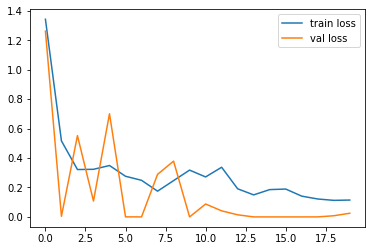

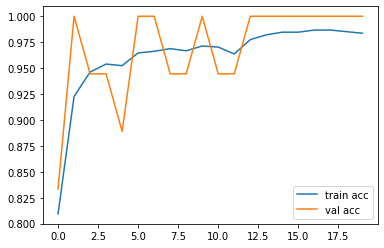

<Figure size 432x288 with 0 Axes>

In [ ]:
# Plotting the loss
plt.plot(r.history['loss'], label='train loss')
plt.plot(r.history['val_loss'], label='val loss')
plt.legend()
plt.show()
plt.savefig('LossVal_loss')

# Plotting the accuracy
plt.plot(r.history['accuracy'], label='train acc')
plt.plot(r.history['val_accuracy'], label='val acc')
plt.legend()
plt.show()
plt.savefig('AccVal_acc')

In [ ]:
# Saving it as a h5 file
from tensorflow.keras.models import load_model
model.save('model_resnet152V2.h5')

In [ ]:
y_pred = model.predict(test_set)

In [ ]:
y_pred

array([[1.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [6.0418418e-13, 9.9821072e-27, 1.0000000e+00, 1.0277375e-21],
       [2.9358501e-20, 5.5044747e-10, 6.1576585e-13, 1.0000000e+00],
       [1.0000000e+00, 3.3567641e-19, 3.3016837e-20, 6.5949765e-27],
       [6.9789524e-28, 0.0000000e+00, 1.0000000e+00, 3.4240018e-34],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [2.7658633e-38, 2.5936642e-30, 1.0000000e+00, 0.0000000e+00],
       [1.6188909e-18, 4.3080657e-08, 1.0000000e+00, 3.9227823e-17],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00],
       [1.7396251e-10, 8.7280595e-13, 3.3145210e-18, 1.0000000e+00],
       [5.2346535e-29, 1.0000000e+00, 1.3816330e-28, 2.5974358e-23],
       [0.0000000e+00, 1.0000000e+00, 1.3075466e-33, 8.3010505e-31],
       [3.4172676e-27, 0.0000000e+00, 1.0000000e+00, 6.1461999e-30],
       [0.0000000e+00, 2.5142413e-

In [ ]:
import numpy as np
y_pred = np.argmax(y_pred, axis=1)

In [ ]:
y_pred

array([0, 2, 3, 0, 2, 1, 2, 2, 1, 1, 3, 1, 1, 2, 3, 3, 3, 0])

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [ ]:
model = load_model('/content/model_resnet152V2.h5')

In [ ]:
img = image.load_img('/content/drive/My Drive/COTTON_DISEASE/test1/fresh cotton leaf/d (341).jpg',target_size=(224,224)) # Selecting a random image for prediction

In [ ]:
x = image.img_to_array(img)
x

array([[[ 85.,  76.,  71.],
        [ 91.,  82.,  77.],
        [ 91.,  82.,  77.],
        ...,
        [ 60.,  56.,  45.],
        [ 62.,  57.,  51.],
        [ 66.,  61.,  55.]],

       [[ 99.,  90.,  85.],
        [112., 103.,  98.],
        [106.,  97.,  88.],
        ...,
        [ 66.,  57.,  52.],
        [ 66.,  61.,  55.],
        [ 65.,  60.,  54.]],

       [[119., 110., 101.],
        [105.,  96.,  91.],
        [142., 133., 124.],
        ...,
        [ 80.,  71.,  66.],
        [ 81.,  72.,  67.],
        [ 58.,  53.,  47.]],

       ...,

       [[176., 226., 153.],
        [171., 221., 148.],
        [173., 223., 150.],
        ...,
        [137., 185., 127.],
        [137., 185., 125.],
        [141., 189., 129.]],

       [[175., 225., 152.],
        [176., 226., 153.],
        [176., 226., 155.],
        ...,
        [133., 181., 123.],
        [132., 180., 120.],
        [138., 186., 126.]],

       [[173., 223., 150.],
        [167., 217., 146.],
        [175., 2

In [ ]:
x.shape

(224, 224, 3)

In [ ]:
x=x/255

In [ ]:
import numpy as np
x = np.expand_dims(x,axis=0)
img_data = preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [ ]:
model.predict(img_data)

array([[0., 1., 0., 0.]], dtype=float32)

In [ ]:
a = np.argmax(model.predict(img_data), axis = 1)

In [ ]:
a == 1

array([ True])